<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#load-data-(combine-if-multiple/day)" data-toc-modified-id="load-data-(combine-if-multiple/day)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>load data (combine if multiple/day)</a></span></li><li><span><a href="#get-lever-direction-response" data-toc-modified-id="get-lever-direction-response-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>get lever direction response</a></span></li><li><span><a href="#get-time-of-pics-on-and-lever-response-(from-spk-data)" data-toc-modified-id="get-time-of-pics-on-and-lever-response-(from-spk-data)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>get time of pics on and lever response (from spk data)</a></span></li><li><span><a href="#get-some-more-trial-info..." data-toc-modified-id="get-some-more-trial-info...-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>get some more trial info...</a></span></li><li><span><a href="#let's-save-useful-time-stamps" data-toc-modified-id="let's-save-useful-time-stamps-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>let's save useful time stamps</a></span></li></ul></div>

Extract useful timestamps and task events from bhv data

In [1]:
import numpy as np
import mat73
from os.path import join as pjoin
import glob
from collections import defaultdict
import matplotlib.pyplot as plt

## load data (combine if multiple/day)

In [2]:
data_dir = "data_clean"
session = "George_2021-01-28"

session_fnames = sorted(glob.glob(pjoin(data_dir, '*'+session+'*')))


In [3]:
%%time
bhv_mat = defaultdict(list)
for f in session_fnames:
    print(f)
    data = mat73.loadmat(f)
    
    data_vars = data["bhvdata"].keys()
    for v in data_vars:
        bhv_mat[v] += data["bhvdata"][v]
    

data_clean/amntprob4x4_George_2021-01-28_A.mat
data_clean/amntprob4x4_George_2021-01-28_B.mat
data_clean/amntprob4x4_George_2021-01-28_C.mat
CPU times: user 1min 2s, sys: 2.23 s, total: 1min 4s
Wall time: 1min 7s


## get lever direction response

In [4]:
# number of trials in this session
ntr = len(bhv_mat["BehavioralCodes"])

In [9]:
# event codes
events = dict()
events["leftlever"] = 23
events["rightlever"] = 24

# which lever?
if_left = [np.where(trial["CodeNumbers"] == events["leftlever"])[0].shape[0] == 1\
             for trial in bhv_mat["BehavioralCodes"]]
if_right = [np.where(trial["CodeNumbers"] == events["rightlever"])[0].shape[0] == 1\
             for trial in bhv_mat["BehavioralCodes"]]
lever_bhv = np.zeros(ntr).astype(int)
lever_bhv[if_left] = -1
lever_bhv[if_right] = 1


Text(0.5, 0, 'lever response')

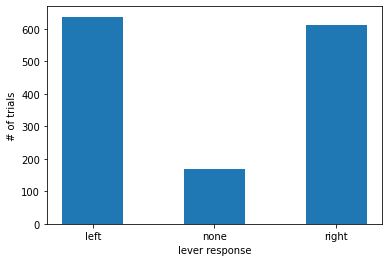

In [10]:
fig, ax = plt.subplots()
ax.hist(lever_bhv, np.arange(-1, 2, .5))
ax.set_xticks([-0.75, 0.25, 1.25])
ax.set_xticklabels(["left", "none", "right"])
ax.set_ylabel("# of trials")
ax.set_xlabel("lever response")

## get time of pics on and lever response (from spk data)

In [11]:
# load events from spk data...
fname_spk = "George00_rec14_01282021-units.mat"
events_pl2 = mat73.loadmat(pjoin(data_dir, fname_spk), only_include=['event_codes', 'event_ts'])

In [12]:
# first, cut up trials: 9 = start, 18 = stop
events["start"] = 9
events["stop"] = 18
events["pics"] = 20
trial_starts = np.where(events_pl2["event_codes"] == events["start"])[0]
trial_stops = np.where(events_pl2["event_codes"] == events["stop"])[0]

In [13]:
# check that we are extracting the same number of trials from bhv and pl2
if trial_starts.shape[0] != ntr or trial_stops.shape[0] != ntr:
    raise ValueError('oops! bhv2 and pl2 trial mismatch...')


In [31]:
# cycle through all trials, pull time of pics on and lever press
ts_pics = -1 * np.ones(ntr)
ts_lever = -1 * np.ones(ntr)
lever_pl2 = np.zeros(ntr)
for tr in range(ntr):
    
    # select event codes in this trial
    trial_codes = events_pl2["event_codes"][trial_starts[tr]:trial_stops[tr]]
    trial_ts = events_pl2["event_ts"][trial_starts[tr]:trial_stops[tr]]
    
    # pics
    idx_pics = np.where(trial_codes == events["pics"])[0]
    if idx_pics.shape[0] == 0: # didn't initiate trial
        continue
        
    ts_pics[tr] = trial_ts[idx_pics]
    
    # lever
    idx_left = np.where(trial_codes == events["leftlever"])[0]
    idx_right = np.where(trial_codes == events["rightlever"])[0]
    
    if idx_left.shape[0] == 1:
        # left lever!
        ts_lever[tr] = trial_ts[idx_left]
        lever_pl2[tr] = -1
    if idx_right.shape[0] == 1:
        # right lever!
        ts_lever[tr] = trial_ts[idx_right]
        lever_pl2[tr] = 1


In [32]:
if sum(lever == lever_pl2) < ntr:
    raise ValueError("bhv and pl2 lever codes don't match")

Text(0, 0.5, 'trial count')

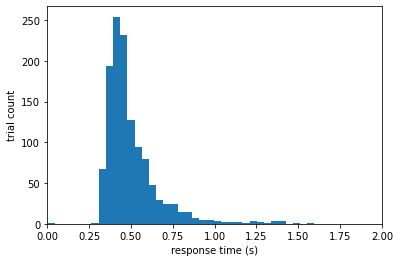

In [33]:
fig, ax = plt.subplots()

rt = ts_lever - ts_pics
keep = np.logical_and(ts_pics > 0, ts_lever > 0)

ax.hist(rt[keep], 100)
ax.set_xlim([0, 2])
ax.set_xlabel("response time (s)")
ax.set_ylabel("trial count")

## get some more trial info...

In [34]:
bhv_mat.keys()

dict_keys(['AbsoluteTrialStartTime', 'AnalogData', 'BehavioralCodes', 'Block', 'Condition', 'CycleRate', 'ObjectStatusRecord', 'ReactionTime', 'RewardRecord', 'TaskObject', 'Trial', 'TrialDateTime', 'TrialError', 'TrialWithinBlock', 'UserVars', 'VariableChanges', 'Ver'])

In [35]:
bhv_mat["TaskObject"][0]["CurrentConditionInfo"][0]

{'amnt': array([1., 5.]),
 'correct': array([1., 2.]),
 'prob': array([0.1    , 0.36667]),
 'stim': 'amnt1_prob1',
 'trialtype': 'free'}

In [36]:
amnt = np.array([C["CurrentConditionInfo"][0]["amnt"].tolist() \
                 for C in bhv_mat["TaskObject"]])

In [37]:
prob = np.array([C["CurrentConditionInfo"][0]["prob"].tolist() \
                 for C in bhv_mat["TaskObject"]])

In [38]:
value = amnt * prob

In [39]:
trialtype = np.array([C["CurrentConditionInfo"][0]["trialtype"] \
                 for C in bhv_mat["TaskObject"]])


## let's save useful time stamps

In [40]:
out_dir = "output"
fname_out = "George00_rec14_01282021-bhvtimes.npz"

np.savez(pjoin(out_dir,fname_out), \
         ts_pics=ts_pics, ts_lever=ts_lever)